# SPAM MESSAGES CLASSIFICATION 
# NLP course - Final project - 2017

In [172]:
import pandas as pd
import numpy as np
import seaborn as sn
import itertools
import matplotlib.pyplot as plt
import operator
import statsmodels.api as sms
import matplotlib
import textwrap
import re
from textblob import TextBlob, Word, WordList

%matplotlib inline

In [173]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [174]:
with open('smsspamcollection/SMSSpamCollection.txt') as f:
    text = f.read()

## Preprocessing

#### Translation

-- Avoid of having message language is different from English

In [175]:
splitted_text_toline = text.splitlines()
len(splitted_text_toline)

5574

In [176]:
splitted_text_toline[:2]

['ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'ham\tOk lar... Joking wif u oni...']

In [177]:
y = []
X = []
for line in splitted_text_toline:
    line = line.split('\t')
    y.append(line[0])
    X.append(line[1])

In [7]:
excluded_2_X = [i for i in X if len(i) > 2]
b = [str(s) for s in excluded_2_X if TextBlob(s).detect_language() != 'en']
b[:10]

['Goodmorning sleeping ga.',
 'Yup... How ü noe leh...',
 'Hey company elama po mudyadhu.',
 'Okie...',
 'Ha ha cool cool chikku chikku:-):-DB-)',
 'Beerage?',
 'You unbelievable faglord',
 'Poyyarikatur,kolathupalayam,unjalur post,erode dis, &lt;#&gt; .',
 'Ard 515 like dat. Y?',
 'Oi. Ami parchi na re. Kicchu kaaj korte iccha korche na. Phone ta tul na. Plz. Plz.']

In [178]:
en_blob = TextBlob(text)
translated_text = en_blob.translate(to='en')

In [179]:
translated_text.split('\n')[:5]

WordList(['ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', 'ham\tOk lar... Joking wif u oni...', "spam\tFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", 'ham\tU dun say so early hor... U c already then say...', "ham\tNah I don't think he goes to usf, he lives around here though"])

#### Spell Correction

In [180]:
corrected_text=[]
for line in translated_text.split('\n'):
    # TextBlob is providing correct method
    corrected_text.append(TextBlob(line).correct())

#### Lemmatization

In [181]:
corrected_text[:5]

[TextBlob("ham	To until during point, crazy.. Available only in boris n great world la e buffets... Line there got more wat..."),
 TextBlob("ham	K war... Joking if u on..."),
 TextBlob("spasm	Free entry in 2 a wily come to win of Up final this must May 2005. Next of to 87121 to receive entry question(st txt rate)T&C's apply 08452810075over18's"),
 TextBlob("ham	U dun say so early for... U c already then say..."),
 TextBlob("ham	Ah I don't think he goes to us, he lives around here though")]

In [182]:
lemma_text = []
for line in corrected_text:
    lemma_text.append(Word(line).lemmatize())

In [183]:
lemma_text[:5]

[TextBlob("ham	To until during point, crazy.. Available only in boris n great world la e buffets... Line there got more wat..."),
 TextBlob("ham	K war... Joking if u on..."),
 TextBlob("spasm	Free entry in 2 a wily come to win of Up final this must May 2005. Next of to 87121 to receive entry question(st txt rate)T&C's apply 08452810075over18's"),
 TextBlob("ham	U dun say so early for... U c already then say..."),
 TextBlob("ham	Ah I don't think he goes to us, he lives around here though")]

#### Singularize

In [184]:
singularized_text = []
for line in lemma_text:
    singularized_text.append(" ".join(line.words.singularize()))

In [185]:
singularized_text[:5]

['ham To until during point crazy Available only in bori n great world la e buffet Line there got more wat',
 'ham K war Joking if u on',
 "spasm Free entry in 2 a wily come to win of Up final thi must May 2005 Next of to 87121 to receive entry question st txt rate T C ' apply 08452810075over18 '",
 'ham U dun say so early for U c already then say',
 "ham Ah I do n't think he go to u he life around here though"]

In [186]:
y = []
X = []
for line in singularized_text:
    line = re.sub(r'(?<=^ham)\s|(?<=^spasm)\s', '\t', line)
    line = line.split('\t')
    
#     print(line, len(line))
    if len(line) == 2:
        y.append(line[0].replace('spasm', 'spam'))
        X.append(line[1])

In [187]:
len(X), len(y)

(5572, 5572)

In [188]:
X[:5]

['To until during point crazy Available only in bori n great world la e buffet Line there got more wat',
 'K war Joking if u on',
 "Free entry in 2 a wily come to win of Up final thi must May 2005 Next of to 87121 to receive entry question st txt rate T C ' apply 08452810075over18 '",
 'U dun say so early for U c already then say',
 "Ah I do n't think he go to u he life around here though"]

In [189]:
y[:5]

['ham', 'ham', 'spam', 'ham', 'ham']

# Check class imbalance

ham     4825
spam     747
dtype: int64


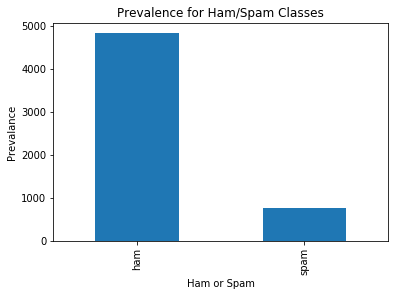

In [190]:
s = pd.Series(y)
print(s.value_counts().sort_index())
axes = s.value_counts().sort_index().plot(kind='bar')
axes.set_xlabel('Ham or Spam')
axes.set_ylabel('Prevalance')
axes.set_title('Prevalence for Ham/Spam Classes')

# EDA

In [191]:
# obtain corpus, vocabulary for all spam and ham messages
from textblob import TextBlob
from collections import Counter

corpus = " ".join(X).lower()
document = TextBlob(corpus)
vocabulary = Counter(document.words)
vocabulary

Counter({'to': 2783,
         'until': 27,
         'during': 9,
         'point': 30,
         'crazy': 15,
         'available': 16,
         'only': 218,
         'in': 983,
         'bori': 9,
         'n': 151,
         'great': 113,
         'world': 42,
         'la': 10,
         'e': 84,
         'buffet': 2,
         'line': 64,
         'there': 276,
         'got': 223,
         'more': 115,
         'wat': 71,
         'k': 247,
         'war': 53,
         'joking': 6,
         'if': 275,
         'u': 1269,
         'on': 525,
         'free': 294,
         'entry': 26,
         '2': 489,
         'a': 1678,
         'wily': 10,
         'come': 246,
         'win': 65,
         'of': 1375,
         'up': 379,
         'final': 18,
         'thi': 270,
         'must': 160,
         'may': 124,
         '2005': 3,
         'next': 105,
         '87121': 4,
         'receive': 39,
         'question': 33,
         'st': 58,
         'txt': 182,
         'rate': 32,
      

In [192]:
# ham
X_ham = [X[i] for i in range(len(y)) if y[i] == 'ham']
X_spam = [X[i] for i in range(len(y)) if y[i] == 'spam']
len(X_ham), len(X_spam), len(X)

(4825, 747, 5572)

In [193]:
# most frequent words of X_ham
corpus_X_ham = " ".join(X_ham).lower().split()
document_ham = TextBlob(" ".join(X_ham).lower())
vocabulary_X_ham = Counter(document_ham.words)

[[<matplotlib.text.Text at 0x3e3706b00>,

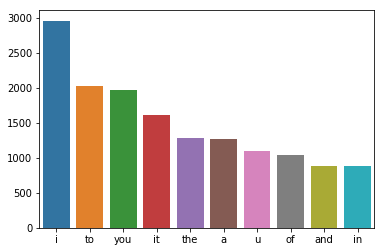

In [194]:
ham_counts_sorted = sorted(vocabulary_X_ham.items(), 
                            key=operator.itemgetter(1),
                            reverse=True)

labels, values = zip(*ham_counts_sorted[:10])

indexes = np.arange(len(labels))
width = 1

# plt.bar(indexes, values, width)
ax = sn.barplot(indexes, values)
ax.set(xticklabels=labels)


[[<matplotlib.text.Text at 0x3e3ff5b70>,

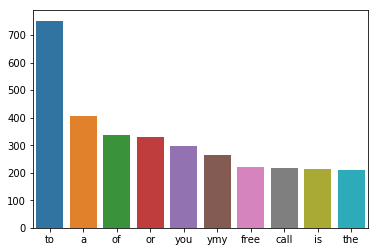

In [195]:
# top 10 most frequent words of X_spam
corpus_X_spam = " ".join(X_spam).lower().split()
document_spam = TextBlob(" ".join(X_spam).lower())
vocabulary_X_spam = Counter(document_spam.words)
spam_counts_sorted = sorted(vocabulary_X_spam.items(), 
                            key=operator.itemgetter(1),
                            reverse=True)

labels, values = zip(*spam_counts_sorted[:10])

indexes = np.arange(len(labels))
width = 1

ax = sn.barplot(indexes, values)
ax.set(xticklabels=labels)
# plt.bar(indexes, values, width)
# plt.xticks(indexes + width * 0.5, labels)

In [196]:
# union = vocabulary_X_spam & vocabulary_X_ham
# union.most_common()[:10]

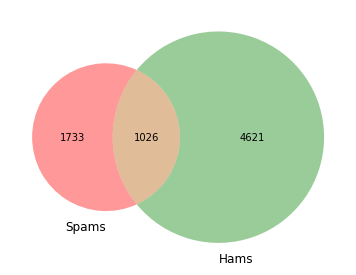

In [197]:
from matplotlib_venn import venn2, venn2_circles

plt.figure(figsize=(6,6))
venn2([vocabulary_X_spam.keys(), vocabulary_X_ham.keys()], ('Spams', 'Hams'),set_colors=('r', 'g'))
plt.show()

In [198]:
len(corpus_X_ham), len(corpus_X_spam)

(70558, 17977)

In [199]:
# X_h = set(corpus_X_ham)
# X_s = set(corpus_X_spam)
# # differences
# diff = X_h.difference(X_s)

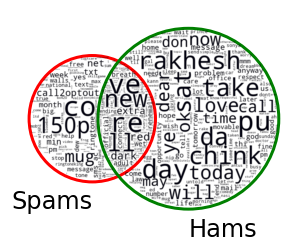

In [200]:
from matplotlib_venn_wordcloud import venn2_wordcloud

# create visualisation
venn2_wordcloud([set(vocabulary_X_spam.keys()), set(vocabulary_X_ham.keys())], ('Spams', 'Hams'),set_colors=['w','w'], set_edgecolors=['r','g'])
plt.show()

In [201]:
spam_keys = set(vocabulary_X_spam).difference(set(vocabulary_X_ham))
ham_keys = set(vocabulary_X_ham).difference(set(vocabulary_X_spam))

In [202]:
ham_words = [(i,v) for i,v in vocabulary_X_ham.items() for j in ham_keys if i == j]
labels = [i for i,v in ham_words]
values = [v for i,v in ham_words]

In [203]:
dh = pd.DataFrame({'labels': labels, 'values': values})
dh = dh.sort_values(by='values', axis=0, ascending=False, inplace=False)

[[<matplotlib.text.Text at 0x3ee04ae48>,

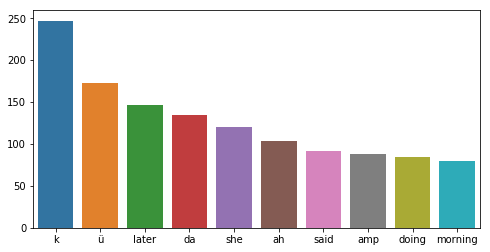

In [204]:
labels, values = np.array(list(dh['labels'])[:10]), list(dh['values'])[:10]
indexes = np.arange(len(labels))
plt.figure(figsize=(8,4))
ax = sn.barplot(indexes, values)
ax.set(xticklabels=labels)


In [225]:
spam_words = [(i,v) for i,v in vocabulary_X_spam.items() for j in spam_keys if i == j]
spam_labels = [i for i,v in spam_words]
spam_values = [v for i,v in spam_words]

In [226]:
dh = pd.DataFrame({'labels': spam_labels, 'values': spam_values})
dh = dh.sort_values(by='values', axis=0, ascending=False, inplace=False)

[[<matplotlib.text.Text at 0x130e3ef28>,

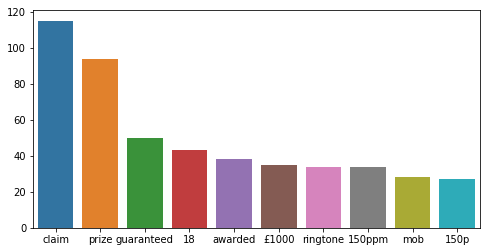

In [227]:
labels, values = np.array(list(dh['labels'])[:10]), list(dh['values'])[:10]
indexes = np.arange(len(labels))
plt.figure(figsize=(8,4))
ax = sn.barplot(indexes, values)
ax.set(xticklabels=labels)


In [228]:
spam_sentence_size = [len(sentence.split()) for sentence in X_spam]
spam_sentence_size = [ i for i,v in Counter(spam_sentence_size).most_common()]
spam_sentence_size[:10]

[27, 24, 28, 26, 25, 22, 29, 23, 30, 19]

In [229]:
ham_sentence_size = [len(sentence.split()) for sentence in X_ham]
ham_sentence_size = [ i for i,v in Counter(ham_sentence_size).most_common()]
ham_sentence_size[:10]

[6, 7, 5, 8, 9, 10, 11, 12, 14, 4]

In [230]:
for sentence in X_ham:
    if len(sentence.split()) == 173:
        phrase = sentence
        print(sentence)

The last thing i ever wanted to do wa hurt you And i did n't think it would have You 'd laugh be embarrassed delete the tag and keep going But a far a i knew it wa n't even up The fact that you even felt like i would do it to hurt you show you really do n't know me at all It wa mes wednesday but it wa n't bad The problem i have with it is you HAVE the time to clean it but you choose not to You type you take picture you sleep you want to go out I do n't mind a few thing here and there but when you do n't make the bed when you throw sundry on top of it when i ca n't have a friend in the house because i 'm embarrassed that there ' underwear and bras strewn on the bed pillow on the floor that ' something else You used to be good about at least making the bed


The last thing i ever wanted to do wa hurt you And i did n't think it would have You 'd laugh be embarrassed delete the tag and keep going But a far a i knew it wa n't even up The fact that you even felt like i would do it to hurt you show you really do n't know me at all It wa mes wednesday but it wa n't bad The problem i have with it is you HAVE the time to clean it but you choose not to You type you take picture you sleep you want to go out I do n't mind a few thing here and there but when you do n't make the bed when you throw sundry on top of it when i ca n't have a friend in the house because i 'm embarrassed that there ' underwear and bras strewn on the bed pillow on the floor that ' something else You used to be good about at least makiing the bed

In [231]:
import string
alphabet = string.ascii_lowercase
print(phrase)

The last thing i ever wanted to do wa hurt you And i did n't think it would have You 'd laugh be embarrassed delete the tag and keep going But a far a i knew it wa n't even up The fact that you even felt like i would do it to hurt you show you really do n't know me at all It wa mes wednesday but it wa n't bad The problem i have with it is you HAVE the time to clean it but you choose not to You type you take picture you sleep you want to go out I do n't mind a few thing here and there but when you do n't make the bed when you throw sundry on top of it when i ca n't have a friend in the house because i 'm embarrassed that there ' underwear and bras strewn on the bed pillow on the floor that ' something else You used to be good about at least making the bed


In [232]:
max(ham_sentence_size), max(spam_sentence_size)

(173, 36)

In [233]:
# len(X_h), len(X_s), len(diff)

In [234]:
# Fit linear model
freq_rank = ((index+1, item[1]) for index, item in enumerate(ham_counts_sorted))
ham_ranks, ham_frequency = zip(*freq_rank)
coeffs = np.polyfit(np.log(ham_ranks), np.log(ham_frequency), deg=1) #Note: Log transform data
poly = np.poly1d(coeffs) 

ham_yfit = lambda x: np.exp(poly(np.log(ham_ranks))) # Define a function that exponentiates the polynomial

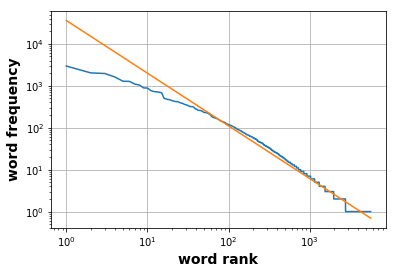

In [235]:
plt.loglog(ham_ranks, ham_frequency) # Plot data
plt.loglog(ham_ranks, ham_yfit(ham_ranks)) # Plot fit line
plt.xlabel('word rank', fontsize=14, fontweight='bold')
plt.ylabel('word frequency', fontsize=14, fontweight='bold')
plt.grid(True)
plt.show()

In [236]:
# Fit linear model
freq_rank = ((index+1, item[1]) for index, item in enumerate(spam_counts_sorted))
ranks, frequency = zip(*freq_rank)
coeffs = np.polyfit(np.log(ranks), np.log(frequency), deg=1) #Note: Log transform data
poly = np.poly1d(coeffs) 

yfit = lambda x: np.exp(poly(np.log(ranks))) # Define a function that exponentiates the polynomial

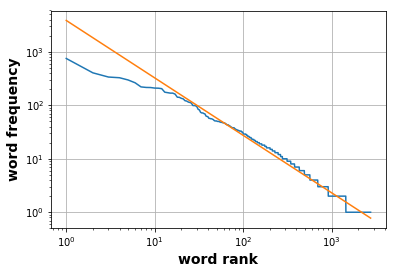

In [237]:
plt.loglog(ranks, frequency) # Plot data
plt.loglog(ranks, yfit(ranks)) # Plot fit line
plt.xlabel('word rank', fontsize=14, fontweight='bold')
plt.ylabel('word frequency', fontsize=14, fontweight='bold')
plt.grid(True)
plt.show()

## NER

In [238]:
from nltk.tag.stanford import StanfordNERTagger
import os

In [239]:
#Use standford NER Tagger as the baseline for identifying LOCATIONS, PERSONS, ORGANIZATIONS
base_path = "./stanford-ner-2014-06-16"
st = StanfordNERTagger(base_path+'/classifiers/all.3class.distsim.crf.ser.gz',
                       base_path+'/stanford-ner.jar')

In [240]:
# Ner spam
ner_spam = st.tag(nltk.word_tokenize(" ".join(" ".join(X_spam).split())))
# ner_spam = st.tag(spam_keys)

spam_others = [i for i,v in ner_spam if v == 'O']
spam_organizations = [i for i,v in ner_spam if v == 'ORGANIZATION']
spam_persons = [i for i,v in ner_spam if v == 'PERSON']

#Ner ham 
ner_ham = st.tag(nltk.word_tokenize(" ".join(" ".join(X_ham).split())))
# ner_ham = st.tag(ham_keys)
others = [i for i,v in ner_ham if v == 'O']
organizations = [i for i,v in ner_ham if v == 'ORGANIZATION']
persons = [i for i,v in ner_ham if v == 'PERSON']


In [241]:
print("---- Spam tags ----")
print('Organization:', len(spam_organizations))
print('Persons:     ', len(spam_persons))
print('Others:      ', len(spam_others))
print("---- Ham tags ----")
print('Organization:', len(organizations))
print('Persons:     ', len(persons))
print('Others:      ', len(others))
print("---- Spam/Ham ----")
print('Organization:', len(spam_organizations)/(len(organizations)+1))
print('Persons:     ', len(spam_persons)/len(persons))
print('Others:      ', len(spam_others)/len(others))

---- Spam tags ----
Organization: 240
Persons:      72
Others:       17615
---- Ham tags ----
Organization: 124
Persons:      223
Others:       70189
---- Spam/Ham ----
Organization: 1.92
Persons:      0.32286995515695066
Others:       0.25096525096525096


* Having less data, however, the propotional ratio between spam and ham showed that spam message usually includes more organizations than a regular message.

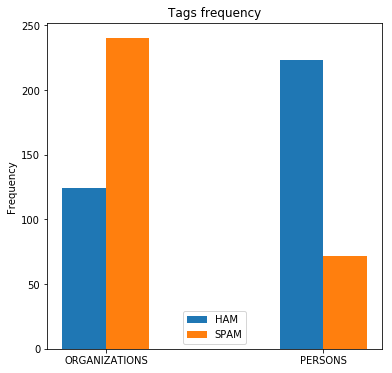

In [242]:
N = 2
ham = [len(organizations),len(persons)]
spam = [len(spam_organizations),len(spam_persons)]
plt.figure(figsize=(6,6))
plt.bar(np.arange(N), ham, width=0.2, label='HAM', align='center')
plt.bar(np.arange(N)+0.2, spam, width=0.2, label='SPAM', align='center')
plt.ylabel('Frequency')
plt.title('Tags frequency')
plt.xticks(np.arange(N)+0.1, ('ORGANIZATIONS', 'PERSONS'))

plt.legend(loc='best')
plt.show()

## Bigram modeling

In [243]:
# our interest is to see how bigram model is able to expose the probability distributions
# of the word given the previous word
import nltk

cfd_spam = nltk.ConditionalFreqDist(nltk.bigrams(corpus_X_spam))
cfd_ham = nltk.ConditionalFreqDist(nltk.bigrams(corpus_X_ham))

In [244]:
# Calculate frequency, MLE and Laplace Smooth Probability
word1 = []
word2 = []
frequency = []
MLE = []
Laplace = []
for word_1, word_2 in nltk.bigrams(corpus_X_spam):
    word1.append(word_1)
    word2.append(word_2)
    frequency.append(cfd_spam[word_1][word_2])
    MLE.append(cfd_spam[word_1].freq(word_2))
    Laplace.append((1+cfd_spam[word_1][word_2]) / (len(vocabulary_X_spam)+cfd_spam[word_1].N()))

df = pd.DataFrame({'frequency': frequency, 'word_2': word2, 'word_1': word1,
                   'MLE': MLE, 'Laplace Smooth Probability': Laplace})
df['word_1_2']= df.word_1 + " " + df.word_2
df = df[['word_1', 'word_2', 'word_1_2', 'frequency', 'MLE', 'Laplace Smooth Probability']]

In [245]:
df = df.drop_duplicates(keep='last')
df = df.sort_values('frequency', ascending=False).reset_index(drop=True)

In [246]:
df

,word_1,word_2,word_1_2,frequency,MLE,Laplace Smooth Probability
0,you,have,you have,75,0.251678,0.024861
1,have,won,have won,54,0.380282,0.018959
2,ymy,mobile,ymy mobile,49,0.185606,0.016540
3,to,claim,to claim,46,0.061170,0.013386
4,please,call,please call,45,0.833333,0.016353
5,won,a,won a,40,0.555556,0.014483
6,to,contact,to contact,37,0.049202,0.010823
7,you,are,you are,36,0.120805,0.012103
8,hi,is,hi is,31,0.659574,0.011404
9,t,is,t is,31,0.442857,0.011311


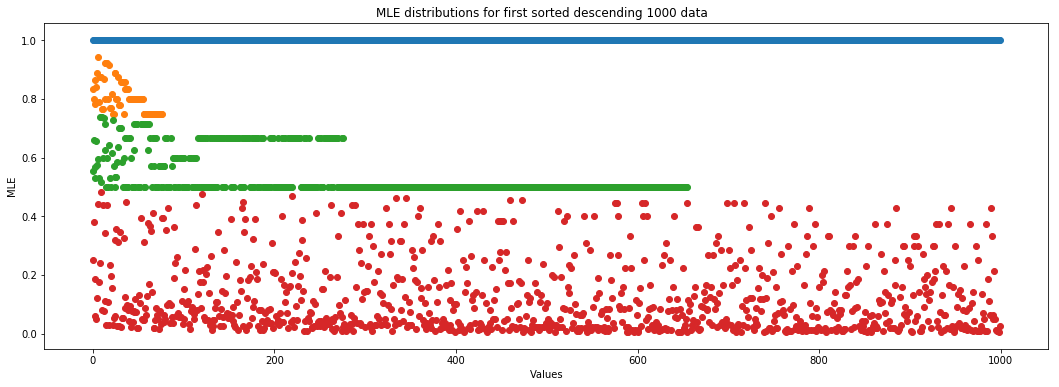

In [247]:
plt.figure(figsize=(18,6))

plt.scatter(np.arange(len(df.MLE[df.MLE >= 0.95][:1000])), df.MLE[df.MLE >= 0.95].values[:1000])
plt.scatter(np.arange(len(df.MLE[df.MLE >= 0.75][df.MLE < 0.95][:1000])), df.MLE[df.MLE >= 0.75][df.MLE < 0.95].values[:1000])
plt.scatter(np.arange(len(df.MLE[df.MLE >= 0.5][df.MLE < 0.75][:1000])), df.MLE[df.MLE >= 0.5][df.MLE < 0.75].values[:1000])
plt.scatter(np.arange(len(df.MLE[df.MLE < 0.5][:1000])), df.MLE[df.MLE < 0.5].values[:1000])

plt.ylabel('MLE')
plt.xlabel('Values')

plt.title('MLE distributions for first sorted descending 1000 data  ')

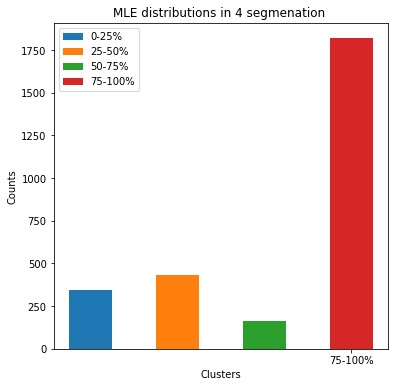

In [248]:
plt.figure(figsize=(6,6))
level1 = df.MLE[df.MLE > 0][df.MLE <= 0.25].sum()
level2 = df.MLE[df.MLE > 0.25][df.MLE <= 0.5].sum() 
level3 = df.MLE[df.MLE > 0.5][df.MLE < 1].sum()
level4 = df.MLE[df.MLE == 1].sum()

plt.bar(np.arange(len([level1])), level1, width=0.1, align='center', label='0-25%')
plt.bar(np.arange(len([level2]))+0.2, level2, width=0.1, align='center', label='25-50%')
plt.bar(np.arange(len([level3]))+0.4, level3, width=0.1, align='center', label='50-75%')

plt.bar(np.arange(len([level4]))+.6, level4, width=0.1, align='center', label='75-100%', tick_label='75-100%')

# plt.ylabel('Frequency')
# plt.title('Tags frequency')
# plt.xticks(np.arange(N))
# plt.ticklabel_format(axis='x')
plt.legend(loc='best')
# plt.show()
plt.ylabel('Counts')
plt.xlabel('Clusters')

plt.title('MLE distributions in 4 segmenation ')
plt.show()

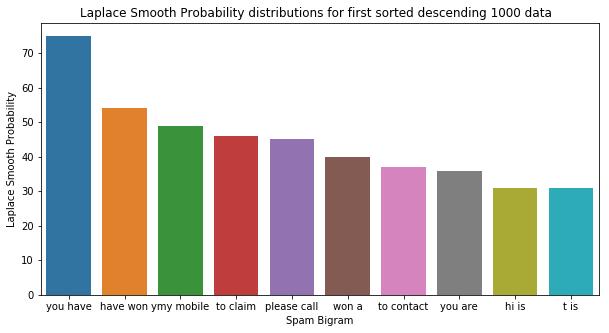

In [256]:
# plt.figure(figsize=(18,6))
labels, values = np.array(list(df['word_1_2'])[:10]), list(df['frequency'])[:10]
indexes = np.arange(len(labels))
plt.figure(figsize=(10,5))
ax = sn.barplot(indexes,values)
ax.set(xticklabels=labels)
plt.ylabel('Laplace Smooth Probability')
plt.xlabel('Spam Bigram')

plt.title('Laplace Smooth Probability distributions for first sorted descending 1000 data  ')

In [250]:
# most frequent words of X_ham
corpus_X_ham = " ".join(X_ham).lower().split()
document_ham = TextBlob(" ".join(X_ham).lower())
vocabulary_X_ham = Counter(document_ham.words)

In [72]:
# import pylab as p
# import scipy
# # plt.scatter(df['frequency'], df['MLE'])
# plt.figure(figsize=(12,6))
# x = np.arange(len(df[:50]))
# y = df.frequency.values[:50]
# plt.scatter(x,y, linewidths=.1)
# d = scipy.zeros(len(y))
# plt.fill_between(x, y, where=y>=d, interpolate=True, color='black', alpha=0.1)

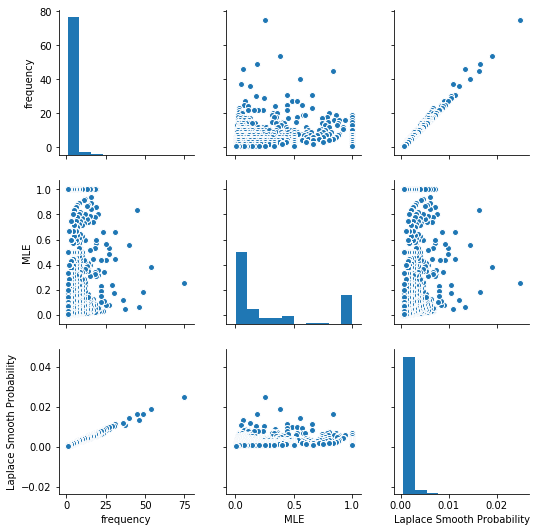

In [73]:
import seaborn as sns

sns.pairplot(df)

In [943]:
# numerics_only = df.select_dtypes(['int64', 'float64'])
# sms.graphics.plot_corr(numerics_only.corr(), xnames=numerics_only.columns.tolist());

In [944]:
import spacy
nlp = spacy.load('en')
doc = nlp(" ".join(X_ham).lower())
for word in doc[:10]:
    print(word.text, word.tag_,  word.tag,  word.pos)



    Only loading the 'en' tokenizer.

to  0 0
until  0 0
during  0 0
point  0 0
crazy  0 0
available  0 0
only  0 0
in  0 0
bori  0 0
n  0 0


In [251]:
# The corpus counts of each bigram in the ham corpus:
word1 = []
word2 = []
frequency = []
MLE = []
Laplace = []
for word_1, word_2 in nltk.bigrams(corpus_X_ham):
    word1.append(word_1)
    word2.append(word_2)
    frequency.append(cfd_ham[word_1][word_2])
    MLE.append(cfd_ham[word_1].freq(word_2))
    Laplace.append((1+cfd_ham[word_1][word_2]) / (len(vocabulary_X_ham)+cfd_ham[word_1].N()))


df1 = pd.DataFrame({'frequency': frequency, 'word_2': word2, 'word_1': word1,
                    'MLE': MLE,'Laplace Smooth Probability': Laplace})
df1['word_1_2']= df1.word_1 + " " + df1.word_2
df1 = df1[['word_1', 'word_2', 'word_1_2', 'frequency', 'MLE', 'Laplace Smooth Probability']]

In [252]:
df1 = df1.drop_duplicates(keep='last')
df1 = df1.sort_values('frequency', ascending=False).reset_index(drop=True)

In [253]:
df1

,word_1,word_2,word_1_2,frequency,MLE,Laplace Smooth Probability
0,i,'m,i 'm,377,0.127494,0.043933
1,it,it,it it,290,0.180348,0.040110
2,are,you,are you,177,0.419431,0.029329
3,i,'ll,i 'll,168,0.056814,0.019642
4,i,am,i am,130,0.043963,0.015225
5,do,n't,do n't,125,0.287356,0.020717
6,have,a,have a,111,0.236674,0.018313
7,i,will,i will,110,0.037200,0.012901
8,to,you,to you,103,0.050714,0.013545
9,i,can,i can,98,0.033142,0.011506


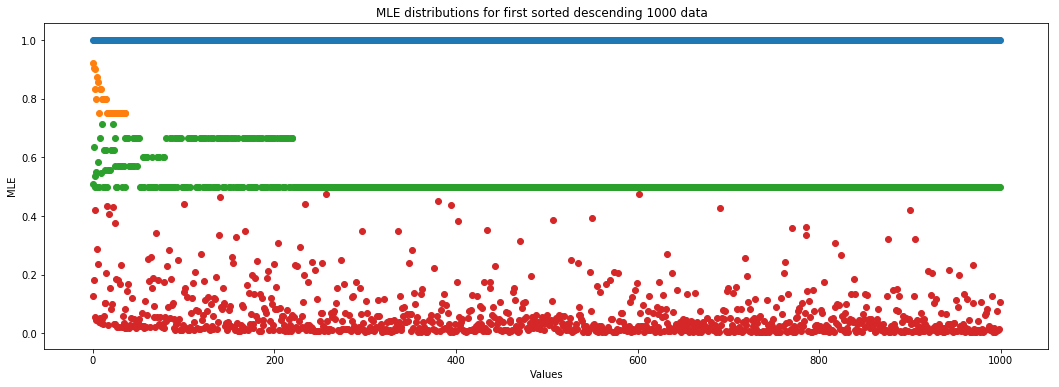

In [254]:
plt.figure(figsize=(18,6))

plt.scatter(np.arange(len(df1.MLE[df1.MLE >= 0.95][:1000])), df1.MLE[df1.MLE >= 0.95].values[:1000])
plt.scatter(np.arange(len(df1.MLE[df1.MLE >= 0.75][df1.MLE < 0.95][:1000])), df1.MLE[df1.MLE >= 0.75][df1.MLE < 0.95].values[:1000])
plt.scatter(np.arange(len(df1.MLE[df1.MLE >= 0.5][df1.MLE < 0.75][:1000])), df1.MLE[df1.MLE >= 0.5][df1.MLE < 0.75].values[:1000])
plt.scatter(np.arange(len(df1.MLE[df1.MLE < 0.5][:1000])), df1.MLE[df1.MLE < 0.5].values[:1000])

plt.ylabel('MLE')
plt.xlabel('Values')

plt.title('MLE distributions for first sorted descending 1000 data  ')

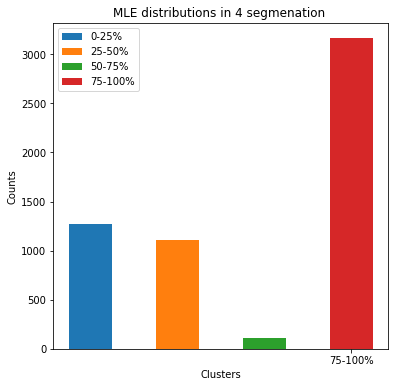

In [255]:
plt.figure(figsize=(6,6))
level1 = df1.MLE[df1.MLE > 0][df1.MLE <= 0.25].sum()
level2 = df1.MLE[df1.MLE > 0.25][df1.MLE <= 0.5].sum() 
level3 = df1.MLE[df1.MLE > 0.5][df1.MLE < 1].sum()
level4 = df1.MLE[df1.MLE == 1].sum()

plt.bar(np.arange(len([level1])), level1, width=0.1, align='center', label='0-25%')
plt.bar(np.arange(len([level2]))+0.2, level2, width=0.1, align='center', label='25-50%')
plt.bar(np.arange(len([level3]))+0.4, level3, width=0.1, align='center', label='50-75%')

plt.bar(np.arange(len([level4]))+.6, level4, width=0.1, align='center', label='75-100%', tick_label='75-100%')

# plt.ylabel('Frequency')
# plt.title('Tags frequency')
# plt.xticks(np.arange(N))
# plt.ticklabel_format(axis='x')
plt.legend(loc='best')
# plt.show()
plt.ylabel('Counts')
plt.xlabel('Clusters')

plt.title('MLE distributions in 4 segmenation ')
plt.show()

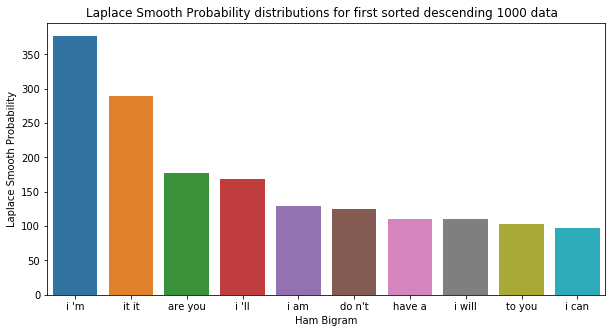

In [258]:
# plt.figure(figsize=(18,6))
labels, values = np.array(list(df1['word_1_2'])[:10]), list(df1['frequency'])[:10]
indexes = np.arange(len(labels))
plt.figure(figsize=(10,5))
ax = sn.barplot(indexes,values)
ax.set(xticklabels=labels)
plt.ylabel('Laplace Smooth Probability')
plt.xlabel('Ham Bigram')

plt.title('Laplace Smooth Probability distributions for first sorted descending 1000 data  ')

In [79]:
l = 100
x, y_ = np.indices((l, l))
center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)
radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y_ - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y_ - center2[1]) ** 2 < radius2 ** 2
circle3 = (x - center3[0]) ** 2 + (y_ - center3[1]) ** 2 < radius3 ** 2
circle4 = (x - center4[0]) ** 2 + (y_ - center4[1]) ** 2 < radius4 ** 2


In [80]:
A=df1.MLE.values

In [81]:
B = np.reshape(A, (-1, 2))

In [82]:
zeros_matrix = np.zeros([len(A),len(A)])

In [83]:
zeros_matrix.fill(0)

In [96]:
dim = 2678
MLE_values = np.zeros([dim,dim])

In [97]:
row,col = np.diag_indices(MLE_values.shape[0])
MLE_values[row,col] = np.array(df1.MLE.values[:dim])
MLE_values

array([[ 0.12749408,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.18034826,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.41943128, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.00196947,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.02424242,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.0058651 ]])

/Users/Tai/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


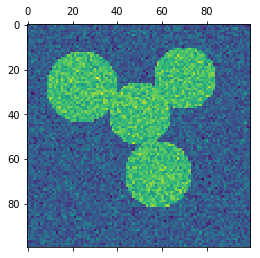

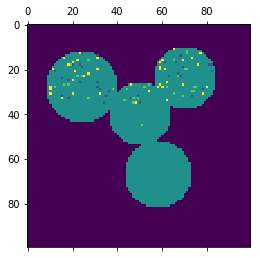

In [98]:
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering


# #############################################################################
# 4 circles
img = circle1 + circle2 + circle3 + circle4

# We use a mask that limits to the foreground: the problem that we are
# interested in here is not separating the objects from the background,
# but separating them one from the other.
mask = img.astype(bool)

img = img.astype(float)
img += 1 + 0.2 * np.random.randn(*img.shape)

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependent from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())

# Force the solver to be arpack, since amg is numerically
# unstable on this example
labels = spectral_clustering(MLE_values, n_clusters=4, eigen_solver='arpack')
label_im = -np.ones(mask.shape)
label_im[mask] = labels

plt.matshow(img)
plt.matshow(label_im)


In [1498]:
graph.todense()

matrix([[ 0.05331274,  0.38952499,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.38952499,  0.13686602,  0.49382915, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.49382915,  0.06758843, ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.0820313 ,
          0.75135424,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.75135424,
          0.06163456,  0.95601563],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.95601563,  0.05892361]])

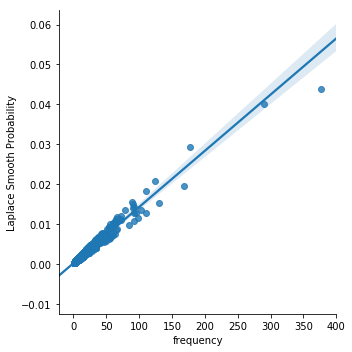

In [948]:
sn.lmplot('frequency', 'Laplace Smooth Probability', df1)

In [949]:
df1.shape

(37704, 6)

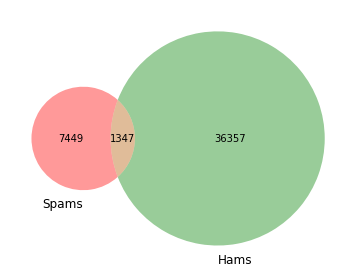

In [169]:
plt.figure(figsize=(6,6))
venn2([set(df.word_1_2.values), set(df1.word_1_2.values)], ('Spams', 'Hams'),set_colors=('r', 'g'))
plt.show()

In [950]:
# # plt.scatter(df['frequency'], df['MLE'])
# plt.figure(figsize=(12,4))
# x = np.arange(len(df1[:50]))
# y = df1.frequency.values[:50]
# plt.scatter(x,y, linewidths=0.01)
# d = scipy.zeros(len(y))
# plt.fill_between(x, y, where=y>=d, interpolate=True, color='black', alpha=0.1)

In [951]:
# df.sort_values('frequency', ascending=False)

In [952]:
# # The corpus counts for each word in the sentence:
# word_ = []
# frequency1 = []
# for word in corpus_X_spam:
#     word_.append(word)
#     frequency1.append(cfd[word].N())
# #     print(f"{word:<8} {cfd[word].N():<8}") 
# corpus_X_spam_count_unigram = [cfd[word].N() for word in corpus_X_spam]
# df1 = pd.DataFrame({'frequency': frequency1, 'word': word_})
# df1 = df1[['word', 'frequency']]
# df1.word.value_counts()[:20]

## CRF model

In [953]:
st_spam_tagged = st.tag(nltk.word_tokenize(" ".join(" ".join(X_spam).split())))
pos_tagged = nltk.pos_tag(nltk.word_tokenize(" ".join(" ".join(X_spam).split())))

In [1172]:
st_ham_tagged = st.tag(nltk.word_tokenize(" ".join(" ".join(X_ham).split())))
pos_ham_tagged = nltk.pos_tag(nltk.word_tokenize(" ".join(" ".join(X_ham).split())))

In [954]:
st_spam_tagged[:5]

[('Free', 'O'), ('entry', 'O'), ('in', 'O'), ('2', 'O'), ('a', 'O')]

In [1175]:
st_ham_tagged[:5]

[('To', 'O'), ('until', 'O'), ('during', 'O'), ('point', 'O'), ('crazy', 'O')]

In [955]:
spam_tagged = []
for i,v in enumerate(st_spam_tagged):
    x = v
    if st_spam_tagged[i][1] == 'O':
        x = (st_spam_tagged[i][0], st_spam_tagged[i][1].replace('O',tagged[i][1]))
    spam_tagged.append(x)

In [1174]:
ham_tagged = []
for i,v in enumerate(st_ham_tagged):
    x = v
    if st_ham_tagged[i][1] == 'O':
        x = (st_ham_tagged[i][0], st_ham_tagged[i][1].replace('O',tagged[i][1]))
    ham_tagged.append(x)

IndexError: list index out of range

In [956]:
spam_tagged[:5]

[('Free', 'JJ'), ('entry', 'NN'), ('in', 'IN'), ('2', 'CD'), ('a', 'DT')]

In [1161]:
spam_X = [x for x,y in st_spam_tagged]
spam_y = [y for x,y in st_spam_tagged]

In [1162]:
from sklearn.model_selection import train_test_split

spam_X_train, spam_X_test, spam_y_train, spam_y_test = train_test_split(spam_X,
                                                    spam_y,
                                                    random_state=42)

In [1163]:
len(spam_X_train), len(spam_X_test), len(spam_y_train), len(spam_y_test)

(13482, 4495, 13482, 4495)

In [1164]:
spam_train_set = list(zip(spam_X_train, spam_y_train))
spam_test_set = list(zip(spam_X_test, spam_y_test))

In [1165]:
def word2features(sent, i):
    word = sent[0]
    postag = sent[1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[0]
        postag1 = sent[1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True # is word at beginning of sentence

    if i < len(sent)-1:
        word1 = sent[0]
        postag1 = sent[1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True # is word at the end of sentence

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [sent[1] for _ in range(len(sent))]

def sent2tokens(sent):
    return [sent[0] for _ in range(len(sent))]

#### Train tags for each message token

In [1166]:
%%time
X_train = [sent2features(s) for s in spam_train_set]
y_train = [sent2labels(s) for s in spam_train_set]

X_test = [sent2features(s) for s in spam_train_set]
y_test = [sent2labels(s) for s in spam_train_set]

CPU times: user 306 ms, sys: 27.4 ms, total: 333 ms
Wall time: 342 ms


In [1167]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 996 ms, sys: 8.31 ms, total: 1 s
Wall time: 1 s


#### Predict tags

In [1168]:
labels = list(crf.classes_)

y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

1.0

#### Evaluate predictions

In [1169]:
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           O      1.000     1.000     1.000     26444
      PERSON      1.000     1.000     1.000       106
    LOCATION      1.000     1.000     1.000        60
ORGANIZATION      1.000     1.000     1.000       354

 avg / total      1.000     1.000     1.000     26964



In [1170]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from[:3], label_to[:3], weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(10))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-10:])

Top likely transitions:
O      -> O       2.697421
ORG    -> ORG     1.895641
PER    -> PER     1.598967
LOC    -> LOC     1.485815
LOC    -> PER     -0.173622
PER    -> LOC     -0.173622
LOC    -> ORG     -0.209752
ORG    -> LOC     -0.209752
ORG    -> PER     -0.245017
PER    -> ORG     -0.245017

Top unlikely transitions:
LOC    -> ORG     -0.209752
ORG    -> LOC     -0.209752
ORG    -> PER     -0.245017
PER    -> ORG     -0.245017
O      -> LOC     -0.371498
LOC    -> O       -0.371498
O      -> PER     -0.398018
PER    -> O       -0.398018
O      -> ORG     -0.441130
ORG    -> O       -0.441130


In [1171]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(10))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-10:])

Top positive:
2.893024 O        postag:O
2.893024 O        postag[:2]:O
2.018257 ORGANIZATION postag:ORGANIZATION
2.018257 ORGANIZATION postag[:2]:OR
1.750264 PERSON   postag:PERSON
1.750264 PERSON   postag[:2]:PE
1.664704 LOCATION postag:LOCATION
1.664704 LOCATION postag[:2]:LO
1.196596 O        +1:postag:O
1.196596 O        +1:postag[:2]:O

Top negative:
0.582505 LOCATION -1:postag:LOCATION
0.582505 LOCATION -1:postag[:2]:LO
0.472668 O        bias
0.088709 LOCATION word.lower():england
0.064668 PERSON   word.lower():foka
0.064578 PERSON   word[-3:]:oka
0.064239 PERSON   word[-2:]:ka
0.020295 LOCATION word[-2:]:on
-0.037150 LOCATION bias
-0.432541 O        word.istitle()


In [1170]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from[:3], label_to[:3], weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(10))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-10:])

Top likely transitions:
O      -> O       2.697421
ORG    -> ORG     1.895641
PER    -> PER     1.598967
LOC    -> LOC     1.485815
LOC    -> PER     -0.173622
PER    -> LOC     -0.173622
LOC    -> ORG     -0.209752
ORG    -> LOC     -0.209752
ORG    -> PER     -0.245017
PER    -> ORG     -0.245017

Top unlikely transitions:
LOC    -> ORG     -0.209752
ORG    -> LOC     -0.209752
ORG    -> PER     -0.245017
PER    -> ORG     -0.245017
O      -> LOC     -0.371498
LOC    -> O       -0.371498
O      -> PER     -0.398018
PER    -> O       -0.398018
O      -> ORG     -0.441130
ORG    -> O       -0.441130


In [1171]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(10))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-10:])

Top positive:
2.893024 O        postag:O
2.893024 O        postag[:2]:O
2.018257 ORGANIZATION postag:ORGANIZATION
2.018257 ORGANIZATION postag[:2]:OR
1.750264 PERSON   postag:PERSON
1.750264 PERSON   postag[:2]:PE
1.664704 LOCATION postag:LOCATION
1.664704 LOCATION postag[:2]:LO
1.196596 O        +1:postag:O
1.196596 O        +1:postag[:2]:O

Top negative:
0.582505 LOCATION -1:postag:LOCATION
0.582505 LOCATION -1:postag[:2]:LO
0.472668 O        bias
0.088709 LOCATION word.lower():england
0.064668 PERSON   word.lower():foka
0.064578 PERSON   word[-3:]:oka
0.064239 PERSON   word[-2:]:ka
0.020295 LOCATION word[-2:]:on
-0.037150 LOCATION bias
-0.432541 O        word.istitle()


## Training w/ CountVectorizer

In [1516]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
len(X_train), len(y_train), len(X_test), len(y_test)

(4179, 4179, 1393, 1393)

In [1517]:
X_train[:5]

['In u r hurt by d ran who s close 2 u do fight wit dem Oz sometime di fight save a relation it being quiet leaf nothing in a relation Mud even',
 "To how ' scotland Hope you are not over showing ymy JJC tendency Take care Give the dream",
 'Never y let I v lazy Not wat At day ü send me da curl can work one',
 "Right femme know what ' up",
 'To we are watching a movie on netflix']

In [1045]:
vectorizer = CountVectorizer()
transformed_X_train = vectorizer.fit_transform(X_train)

In [1056]:
transformed_X_train.todense()[0:5]

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [1057]:
transformed_X_train.shape

(4179, 5766)

### SVM

In [1103]:
count_vect = CountVectorizer()
count_vect.fit(X_train)
svm_clf = SGDClassifier()
svm_clf.fit(count_vect.transform(X_train), y_train)

/Users/Tai/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [1104]:
svm_predictions = svm_clf.predict(count_vect.transform(X_test))

In [1105]:
svm_precision = precision_score(y_test, svm_predictions , pos_label='ham')
svm_recall = recall_score(y_test, svm_predictions, pos_label='ham')
svm_f1 = f1_score(y_test, svm_predictions, pos_label='ham')
svm_confusion_table = confusion_matrix(y_test, svm_predictions)

### MultinomialNB

In [1078]:
# print("There are {:,} words in the vocabulary.".format(len(vectorizer.vocabulary_)))
# print("'{}' appers {:,} times.".format('daddy', vectorizer.vocabulary_['daddy']))

In [1096]:
multinomialNB = MultinomialNB()
multinomialNB.fit(transformed_X_train, y_train)
nb_predictions = multinomialNB.predict(vectorizer.transform(X_test))

In [1097]:
nb_precision = precision_score(y_test, prediction, pos_label='ham')
nb_recall = recall_score(y_test, prediction, pos_label='ham')
nb_f1 = f1_score(y_test, prediction, pos_label='ham')
nb_confusion_table = confusion_matrix(y_test, nb_predictions)

### Logistic Regression

In [1075]:
lr = LogisticRegression()
lr.fit(transformed_X_train, y_train)
lr_predictions = lr.predict(vectorizer.transform(X_test))

In [1086]:
lr_precision = precision_score(y_test, lr_predictions, pos_label='ham')
lr_recall = recall_score(y_test, lr_predictions, pos_label='ham')
lr_f1 = f1_score(y_test, lr_predictions, pos_label='ham')
lr_confusion_table = confusion_matrix(y_test, lr_predictions)

## Evaluation

-----------MultinomialNB-----------
Precision: 0.9884009942
Recall   : 0.993338884263
F1_score : 0.990863787375

-----------Logistic Regression-----------
Precision: 0.979575163399
Recall   : 0.998334721066
F1_score : 0.988865979381

-----------SVM-----------
Precision: 0.974776240846
Recall   : 0.997502081599
F1_score : 0.986008230453


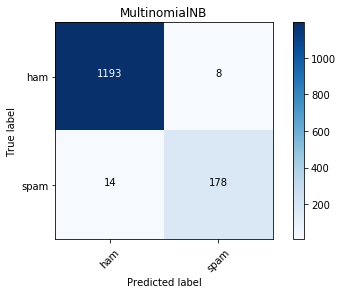

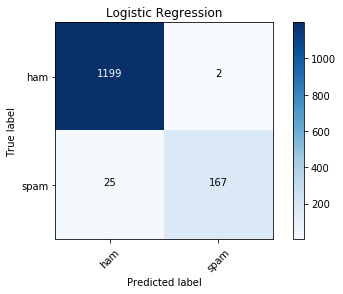

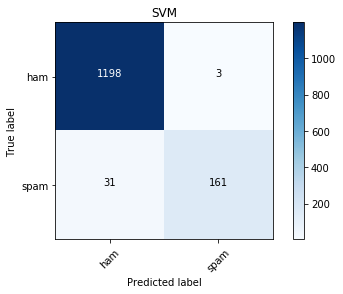

In [1110]:
print("-----------MultinomialNB-----------")
print("Precision:", nb_precision)
print("Recall   :", nb_recall)
print("F1_score :", nb_f1)
plt.figure()
plot_confusion_matrix(nb_confusion_table, classes=['ham','spam'],
                      title='MultinomialNB')
print("\n-----------Logistic Regression-----------")
print("Precision:", lr_precision)
print("Recall   :", lr_recall)
print("F1_score :", lr_f1)
# print("Confusion table:\n", lr_confusion_table)
plt.figure()
plot_confusion_matrix(lr_confusion_table, classes=['ham','spam'],
                      title='Logistic Regression')
print("\n-----------SVM-----------")
print("Precision:", svm_precision)
print("Recall   :", svm_recall)
print("F1_score :", svm_f1)
plt.figure()
plot_confusion_matrix(svm_confusion_table, classes=['ham','spam'],
                      title='SVM')

In [1015]:
# import matplotlib.pyplot as plt

# df_cm = pd.DataFrame(confusion_table, index = [i for i in ['Actual ham', 'Actual spam']],
#                   columns = [i for i in ['ham','spam']])
# plt.figure(figsize = (10,7))
# sn.heatmap(df_cm, annot=True)

In [1111]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## K-fold cv / Undersampling

In [1147]:
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB

vectorizer = CountVectorizer()
transformed_X = vectorizer.fit_transform(X)
target = np.array(y)
train = transformed_X
clf1 = MultinomialNB()
clf2 = SGDClassifier()
clf3 = LogisticRegression()

#Simple K-Fold cross validation. 10 folds.
cv = cross_validation.KFold(len(target), n_folds=10)
for clf,name in [(clf1, 'MultinomialNB'), (clf2, 'SVM'), (clf3, 'Logistic Regression')]:
    results = []
    a, p,r,f1_ = [], [], [], []
    i=0
    print("-----------------------------------------",name,"----------------------------------------------------")
    print("          | Accuracy:\t\t | Precision score:\t | Recall score:\t | F1 score:   ")
    print("-------------------------------------------------------------------------------------------------")
    for traincv, testcv in cv:
        X_t = train[traincv]
        y_t = target[traincv]
        probas = clf.fit(X_t, y_t)
        predictions = probas.predict(train[testcv])
        acc = sum(target[testcv] == predictions)/len(predictions)
        p_score = precision_score(target[testcv], predictions, pos_label='ham')
        r_score = recall_score(target[testcv], predictions, pos_label='ham')
        f1 = f1_score(target[testcv], predictions, pos_label='ham')
        a.append(acc)
        p.append(p_score)
        r.append(r_score)
        f1_.append(f1)
        print("K-Fold", i, ":|", acc, "\t","|", p_score ,"\t", "|",r_score, "\t", "|", f1)
        i+=1
    print("-------------------------------------------------------------------------------------------------")
    print("    Mean :|", np.mean(a),"\t | ", np.mean(p),"\t | ", np.mean(r), "\t | ", np.mean(f1_))
    print()

/Users/Tai/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


----------------------------------------- MultinomialNB ----------------------------------------------------
          | Accuracy:		 | Precision score:	 | Recall score:	 | F1 score:   
-------------------------------------------------------------------------------------------------
K-Fold 0 :| 0.982078853047 	 | 0.995762711864 	 | 0.983263598326 	 | 0.989473684211
K-Fold 1 :| 0.985663082437 	 | 0.99358974359 	 | 0.989361702128 	 | 0.991471215352
K-Fold 2 :| 0.982046678636 	 | 0.987755102041 	 | 0.991803278689 	 | 0.989775051125
K-Fold 3 :| 0.985637342908 	 | 0.993788819876 	 | 0.989690721649 	 | 0.99173553719
K-Fold 4 :| 0.971274685817 	 | 0.981519507187 	 | 0.985567010309 	 | 0.98353909465
K-Fold 5 :| 0.983842010772 	 | 0.993865030675 	 | 0.987804878049 	 | 0.990825688073
K-Fold 6 :| 0.978456014363 	 | 0.985596707819 	 | 0.989669421488 	 | 0.987628865979
K-Fold 7 :| 0.983842010772 	 | 0.989473684211 	 | 0.991561181435 	 | 0.990516332982
K-Fold 8 :| 0.96947935368 	 | 0.989517819706 	 |

## Training w/ tf-idf vectorizer

In [979]:
# vectorizer = CountVectorizer()
# transformed_X_train = vectorizer.fit_transform(X_train)

In [1115]:
vectorizer = TfidfVectorizer()
transformed_X_train = vectorizer.fit_transform(X_train)

In [1021]:
print("There are {:,} words in the vocabulary.".format(len(vectorizer.vocabulary_)))
print("'{}' appers {:,} times.".format('daddy', vectorizer.vocabulary_['daddy']))

There are 5,766 words in the vocabulary.
'daddy' appers 1,641 times.


In [1022]:
multinomialNB = MultinomialNB()
gaussianNB = GaussianNB()
gaussianNB.fit(transformed_X_train.toarray(), y_train)
prediction = gaussianNB.predict(vectorizer.transform(X_test).toarray())


### SVM

In [1112]:
count_vect = TfidfVectorizer()
count_vect.fit(X_train)
svm_clf = SGDClassifier()
svm_clf.fit(count_vect.transform(X_train), y_train)

/Users/Tai/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [1113]:
svm_predictions = svm_clf.predict(count_vect.transform(X_test))

In [1114]:
svm_precision = precision_score(y_test, svm_predictions , pos_label='ham')
svm_recall = recall_score(y_test, svm_predictions, pos_label='ham')
svm_f1 = f1_score(y_test, svm_predictions, pos_label='ham')
svm_confusion_table = confusion_matrix(y_test, svm_predictions)

### MultinomialNB

In [1078]:
# print("There are {:,} words in the vocabulary.".format(len(vectorizer.vocabulary_)))
# print("'{}' appers {:,} times.".format('daddy', vectorizer.vocabulary_['daddy']))

In [1116]:
multinomialNB = MultinomialNB()
multinomialNB.fit(transformed_X_train, y_train)
nb_predictions = multinomialNB.predict(vectorizer.transform(X_test))

In [1117]:
nb_precision = precision_score(y_test, prediction, pos_label='ham')
nb_recall = recall_score(y_test, prediction, pos_label='ham')
nb_f1 = f1_score(y_test, prediction, pos_label='ham')
nb_confusion_table = confusion_matrix(y_test, nb_predictions)

### Logistic Regression

In [1118]:
lr = LogisticRegression()
lr.fit(transformed_X_train, y_train)
lr_predictions = lr.predict(vectorizer.transform(X_test))

In [1119]:
lr_precision = precision_score(y_test, lr_predictions, pos_label='ham')
lr_recall = recall_score(y_test, lr_predictions, pos_label='ham')
lr_f1 = f1_score(y_test, lr_predictions, pos_label='ham')
lr_confusion_table = confusion_matrix(y_test, lr_predictions)

## Evaluation

-----------MultinomialNB-----------
Precision: 0.9884009942
Recall   : 0.993338884263
F1_score : 0.990863787375

-----------Logistic Regression-----------
Precision: 0.965350523771
Recall   : 0.997502081599
F1_score : 0.981162981163

-----------SVM-----------
Precision: 0.987613542527
Recall   : 0.995836802664
F1_score : 0.991708126036


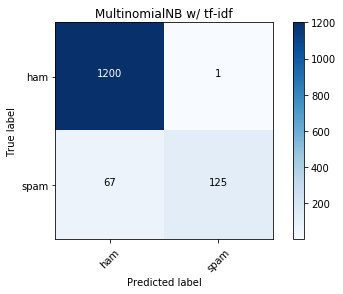

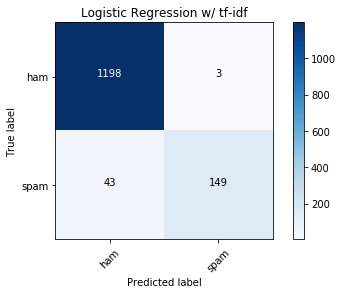

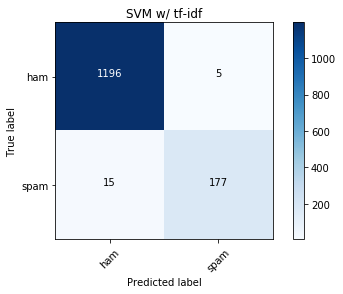

In [1121]:
print("-----------MultinomialNB-----------")
print("Precision:", nb_precision)
print("Recall   :", nb_recall)
print("F1_score :", nb_f1)
plt.figure()
plot_confusion_matrix(nb_confusion_table, classes=['ham','spam'],
                      title='MultinomialNB w/ tf-idf')
print("\n-----------Logistic Regression-----------")
print("Precision:", lr_precision)
print("Recall   :", lr_recall)
print("F1_score :", lr_f1)
# print("Confusion table:\n", lr_confusion_table)
plt.figure()
plot_confusion_matrix(lr_confusion_table, classes=['ham','spam'],
                      title='Logistic Regression w/ tf-idf')
print("\n-----------SVM-----------")
print("Precision:", svm_precision)
print("Recall   :", svm_recall)
print("F1_score :", svm_f1)
plt.figure()
plot_confusion_matrix(svm_confusion_table, classes=['ham','spam'],
                      title='SVM w/ tf-idf')

## K-fold cv / Undersampling

In [1131]:
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB

vectorizer = TfidfVectorizer()
transformed_X = vectorizer.fit_transform(X)
target = np.array(y)
train = transformed_X
clf1 = MultinomialNB()
clf2 = SGDClassifier()
clf3 = LogisticRegression()

#Simple K-Fold cross validation. 10 folds.
cv = cross_validation.KFold(len(target), n_folds=10)
for clf,name in [(clf1, 'MultinomialNB'), (clf2, 'SVM'), (clf3, 'Logistic Regression')]:
    results = []
    a, p,r,f1_ = [], [], [], []
    i=0
    print(name)
    print("          | Accuracy:\t\t | Precision score:\t | Recall score:\t | F1 score:   ")
    print("-------------------------------------------------------------------------------------------------")
    for traincv, testcv in cv:
        X_t = train[traincv]
        y_t = target[traincv]
        probas = clf.fit(X_t, y_t)
        predictions = probas.predict(train[testcv])
        acc = sum(target[testcv] == predictions)/len(predictions)
        p_score = precision_score(target[testcv], predictions, pos_label='ham')
        r_score = recall_score(target[testcv], predictions, pos_label='ham')
        f1 = f1_score(target[testcv], predictions, pos_label='ham')
        a.append(acc)
        p.append(p_score)
        r.append(r_score)
        f1_.append(f1)
        print("K-Fold", i, ":|", acc, "\t","|", p_score ,"\t", "|",r_score, "\t", "|", f1)
        i+=1
    print("    Mean : ", np.mean(a),"\t  ", np.mean(p),"\t  ", np.mean(r), "\t  ", np.mean(f1_))

/Users/Tai/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


MultinomialNB
          | Accuracy:		 | Precision score:	 | Recall score:	 | F1 score:   
-------------------------------------------------------------------------------------------------
K-Fold 0 :| 0.965949820789 	 | 0.961770623742 	 | 1.0 	 | 0.980512820513
K-Fold 1 :| 0.953405017921 	 | 0.947580645161 	 | 1.0 	 | 0.973084886128
K-Fold 2 :| 0.94973070018 	 | 0.945736434109 	 | 1.0 	 | 0.972111553785
K-Fold 3 :| 0.973070017953 	 | 0.97 	 | 1.0 	 | 0.984771573604
K-Fold 4 :| 0.94973070018 	 | 0.945419103314 	 | 1.0 	 | 0.971943887776
K-Fold 5 :| 0.964093357271 	 | 0.9609375 	 | 1.0 	 | 0.980079681275
K-Fold 6 :| 0.958707360862 	 | 0.954635108481 	 | 1.0 	 | 0.976791120081
K-Fold 7 :| 0.953321364452 	 | 0.948 	 | 1.0 	 | 0.973305954825
K-Fold 8 :| 0.956912028725 	 | 0.954545454545 	 | 0.997933884298 	 | 0.975757575758
K-Fold 9 :| 0.960502692998 	 | 0.956607495069 	 | 1.0 	 | 0.977822580645
    Mean :  0.958542306133 	   0.954523236442 	   0.99979338843 	   0.976618163439
SVM
          